**Prédiction des gagnants du jeu d'échecs**

1. Introduction :
Dans ce projet, nous allons prédire les gagnants d'un jeu d'échecs en utilisant différentes techniques d'apprentissage automatique. Nous avons un ensemble de données contenant des informations sur les parties d'échecs jouées sur la plate-forme en ligne "Lichess". L'objectif est de prédire le gagnant en utilisant différentes variables telles que le nombre de coups, le temps, l'ouverture jouée, etc.



In [1]:
#Importing Required Libraries
import numpy as np
import pandas as pd 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import os

from sklearn import model_selection
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC 
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
#Reading data
game = pd.read_csv('chess_games.csv')
game.head(1)

,game_id,rated,turns,victory_status,winner,time_increment,white_id,white_rating,black_id,black_rating,moves,opening_code,opening_moves,opening_fullname,opening_shortname,opening_response,opening_variation
0,1,False,13,Out of Time,White,15+2,bourgris,1500,a-00,1191,d4 d5 c4 c6 cxd5 e6 dxe6 fxe6 Nf3 Bb4+ Nc3 Ba5...,D10,5,Slav Defense: Exchange Variation,Slav Defense,NaN,Exchange Variation


2.Exploration des données
Nous avons commencé par explorer les données pour comprendre la structure et les variables de l'ensemble de données. Nous avons utilisé différentes techniques de visualisation telles que des histogrammes, des nuages de points et des cartes de chaleur pour comprendre les relations entre les variables et les gagnants. Nous avons également vérifié les données manquantes et les données aberrantes.
Ces informations ont était réalisé en amont de ce notebook, dans les notebooks de nettoyage et de modélisation. 

Nous avons de plus utilisé la librairie pychess pour simuler les différentes parties d'échecs, grace à la colonne moves. Mais nous n'avons pas réussi à utiliser ces données pour la prédiction des gagnants. Nous avons donc supprimé cette partie du notebook.

In [3]:
#Checking thhe shape of the dataset
game.shape

(20058, 17)

3. Préparation des données
4. 
Nous avons supprimé les variables non nécessaires pour la prédiction, telles que les identifiants de joueur, le statut de victoire, les temps d'incrémentation, etc. Nous avons également encodé les variables catégorielles en utilisant l'encodage par étiquette. Nous avons ensuite divisé l'ensemble de données en ensembles d'entraînement et de test en utilisant la fonction train_test_split.

Nous avons réalliséé différents test sur les variables, pour voir si elles étaient pertinentes pour la prédiction des gagnants. En utilisant 'opening_fullname' par exemple, mais le score était légérement moins bon que celui actuel. Nous avons garder le jeu de variable qui nous a donné le meilleur score.

In [4]:
#Dropping columns
data=game.drop(labels=['rated','victory_status','time_increment','white_id','black_id','moves','opening_fullname','opening_variation','opening_response'],axis=1)
data.shape

(20058, 8)

In [5]:
le = LabelEncoder()
target = le.fit_transform(data['winner'])
target

array([2, 0, 2, ..., 2, 2, 0])

In [6]:
le2 = LabelEncoder()
data['opening_shortname'] = le2.fit_transform(data['opening_shortname'])
data.head()

,game_id,turns,winner,white_rating,black_rating,opening_code,opening_moves,opening_shortname
0,1,13,White,1500,1191,D10,5,110
1,2,16,Black,1322,1261,B00,4,74
2,3,61,White,1496,1500,C20,3,61
3,4,61,White,1439,1454,D02,3,94
4,5,95,White,1523,1469,C41,5,83


In [7]:
# Checking for missing value counts
print(data.isnull().sum())

game_id              0
turns                0
winner               0
white_rating         0
black_rating         0
opening_code         0
opening_moves        0
opening_shortname    0
dtype: int64


In [8]:
data.dtypes

game_id               int64
turns                 int64
winner               object
white_rating          int64
black_rating          int64
opening_code         object
opening_moves         int64
opening_shortname     int32
dtype: object

<AxesSubplot:xlabel='opening_moves', ylabel='Count'>

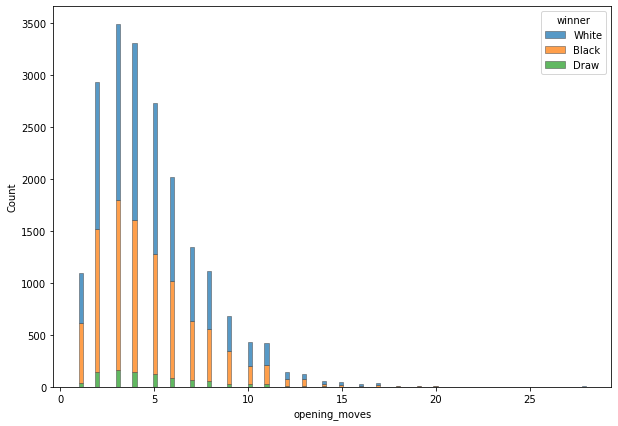

In [9]:
f, ax = plt.subplots(figsize=(10,7))
sns.histplot(x="opening_moves", hue="winner", data=data, multiple='stack', linewidth=0.5, edgecolor=".3")

In [10]:
# Function to split the dataset
def splitdataset(balance_data,target):
  
    # Separating the target variable
    X = balance_data.values[:,[1,3,4,6,7]]
    Y = target
  
    # Splitting the dataset into train and test
    X_train, X_test, y_train, y_test = train_test_split( 
    X, Y, test_size = 0.15, random_state = 40)
      
    return X, Y, X_train, X_test, y_train, y_test

4. Entrainement des modèles
Nous avons utilisé plusieurs techniques d'apprentissage automatique pour prédire le gagnant. Nous avons utilisé des arbres de décision avec l'indice de Gini et l'entropie, la SVM, la régression logistique et les forêts aléatoires. Nous avons entraîné chaque modèle en utilisant l'ensemble d'entraînement et avons prédit les gagnants en utilisant l'ensemble de test.



In [11]:
# Function to perform training with Decision Tree || giniIndex.
def train_using_gini(X_train, X_test, y_train):
    # Creating the classifier object
    clf_gini = DecisionTreeClassifier(criterion = "gini",random_state = 100,max_depth=8, min_samples_leaf=8)
    # Performing training
    clf_gini.fit(X_train, y_train)
    return clf_gini
      
# Function to perform training with Decision Tree || entropy.
def train_using_entropy(X_train, X_test, y_train):
    # Decision tree with entropy
    clf_entropy = DecisionTreeClassifier(
            criterion = "entropy", random_state = 100,max_depth=50, min_samples_leaf = 8)  
    # Performing training
    clf_entropy.fit(X_train, y_train)
    return clf_entropy

# Function to perform training with SVM
def train_using_SVM(X_train, X_test, y_train):
    # Creating the SVM classifier object
    clf_SVM = SVC(kernel='rbf',C=1.4,gamma='scale')
    #Training SVM
    clf_SVM.fit(X_train, y_train) 
    return clf_SVM

# Function to perform training with Logistic Regression
def train_using_logistic(X_train, X_test, y_train):
    # Creating the Logistic classifier object
    clf_logistic = LogisticRegression(solver='liblinear')
    #Training Logistic classifier
    clf_logistic.fit(X_train, y_train)
    return clf_logistic

def train_using_randomforest(X_train, X_test, y_train):
    clf_randomF = RandomForestClassifier(n_estimators = 100)
    clf_randomF.fit(X_train, y_train)
    return clf_randomF

In [12]:
# Function to make predictions
def prediction(X_test, clf_object):
  
    # Predicton on test with giniIndex
    y_pred = clf_object.predict(X_test)
    print("Predicted values:")
    print(y_pred,"\n")
    return y_pred

5. Évaluation
Nous avons évalué chaque modèle en utilisant la précision, le rappel, la F-mesure et le score AUC-ROC.

In [13]:
# Function to calculate accuracy
def cal_accuracy(y_test, y_pred):
      
    print ("\nAccuracy : ",
    accuracy_score(y_test,y_pred)*100)
    print("\n")
      
    print("Report : ",
    classification_report(y_test, y_pred))

In [14]:
# Building Phase
X, Y, X_train, X_test, y_train, y_test = splitdataset(data,target)
clf_gini = train_using_gini(X_train, X_test, y_train)
clf_entropy = train_using_entropy(X_train, X_test, y_train)
clf_SVM = train_using_SVM(X_train, X_test, y_train)
clf_logistic = train_using_logistic(X_train, X_test, y_train)
clf_randomF = train_using_randomforest(X_train, X_test, y_train)

In [15]:
print("Results Using Decision Tree || Gini Index:\n")
      
# Prediction using gini
y_pred_gini = prediction(X_test,clf_gini)
cal_accuracy(y_test, y_pred_gini)

Results Using Decision Tree || Gini Index:

Predicted values:
[2 2 2 ... 0 2 2] 


Accuracy :  62.97773346626786


Report :                precision    recall  f1-score   support

           0       0.64      0.52      0.57      1337
           1       0.40      0.01      0.03       142
           2       0.62      0.79      0.69      1530

    accuracy                           0.63      3009
   macro avg       0.56      0.44      0.43      3009
weighted avg       0.62      0.63      0.61      3009



In [16]:
print("Results Using Decision Tree || Entropy:\n")

# Prediction using entropy
y_pred_entropy = prediction(X_test, clf_entropy)
cal_accuracy(y_test, y_pred_entropy)

Results Using Decision Tree || Entropy:

Predicted values:
[0 0 2 ... 2 0 0] 


Accuracy :  66.56696576935859


Report :                precision    recall  f1-score   support

           0       0.64      0.69      0.67      1337
           1       0.24      0.06      0.09       142
           2       0.70      0.70      0.70      1530

    accuracy                           0.67      3009
   macro avg       0.52      0.48      0.49      3009
weighted avg       0.65      0.67      0.66      3009



In [17]:
print("Results Using SVM Classifier:\n")

# Prediction using SVM
y_pred_SVM = prediction(X_test, clf_SVM)
cal_accuracy(y_test, y_pred_SVM)

Results Using SVM Classifier:

Predicted values:
[2 2 2 ... 2 2 2] 


Accuracy :  63.808574277168496


Report :                precision    recall  f1-score   support

           0       0.65      0.55      0.59      1337
           1       0.00      0.00      0.00       142
           2       0.63      0.77      0.70      1530

    accuracy                           0.64      3009
   macro avg       0.43      0.44      0.43      3009
weighted avg       0.61      0.64      0.62      3009



c:\Users\adrie\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adrie\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\adrie\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\metrics\_classification.py:1308: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [18]:
print("Results Using Logistic Regression:\n")
      
# Prediction using Logistic Regression
y_pred_logistic = prediction(X_test,clf_logistic)
cal_accuracy(y_test, y_pred_logistic)

Results Using Logistic Regression:

Predicted values:
[2 2 2 ... 2 2 2] 


Accuracy :  63.34330342306414


Report :                precision    recall  f1-score   support

           0       0.62      0.59      0.61      1337
           1       0.50      0.01      0.01       142
           2       0.64      0.73      0.68      1530

    accuracy                           0.63      3009
   macro avg       0.59      0.44      0.43      3009
weighted avg       0.63      0.63      0.62      3009



In [19]:
print("Results Using Random Forest\n")
      
# Prediction using Random Forest
y_pred_randomF = prediction(X_test,clf_randomF)
cal_accuracy(y_test, y_pred_randomF)

Results Using Random Forest

Predicted values:
[2 0 2 ... 2 2 2] 


Accuracy :  67.19840478564308


Report :                precision    recall  f1-score   support

           0       0.65      0.66      0.66      1337
           1       0.58      0.13      0.22       142
           2       0.69      0.73      0.71      1530

    accuracy                           0.67      3009
   macro avg       0.64      0.51      0.53      3009
weighted avg       0.67      0.67      0.66      3009



6.Conclusion

Nous avons constaté que les modèles d'arbre de décision avec l'indice de Gini, SVM et la regression logistiques ont donné des performances similaires, tandis que l'entropie et les forêts aléatoires ont donné des performances légèrement supérieures. La Foréts aléaoire a donné la meilleure performance globale avec une précision de 67%. Dans l'ensemble, nous avons pu prédire les gagnants du jeu d'échecs avec une précision moyen en utilisant différentes techniques d'apprentissage automatique.
